# DEMO: Missingness module

This notebook provides a demo of how to utilise the missingness module.

In [1]:
import sys
sys.path.append('../../')

import numpy as np
import pandas as pd
import niimpy
from niimpy.EDA import EDA_missingness

## Load data
We will create a mock missingess dataframe.

In [2]:
df = niimpy.util.create_missing_dataframe(nrows=60*24*30, ncols=5, density=0.2, index_type='dt', freq='T')
df

,0,1,2,3,4
2022-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN
2022-01-01 00:01:00,NaN,NaN,16.297021,NaN,NaN
2022-01-01 00:02:00,NaN,75.735995,NaN,NaN,NaN
2022-01-01 00:03:00,NaN,NaN,NaN,NaN,NaN
2022-01-01 00:04:00,NaN,43.882560,64.445764,NaN,NaN
...,...,...,...,...,...
2022-01-30 23:55:00,NaN,NaN,NaN,NaN,37.749782
2022-01-30 23:56:00,78.860563,8.988251,92.978199,89.227315,41.337187
2022-01-30 23:57:00,NaN,NaN,NaN,NaN,52.763901
2022-01-30 23:58:00,NaN,46.773469,6.920939,NaN,68.643558


## Visualization

First, we create a histogram to visualize data frequency per column.

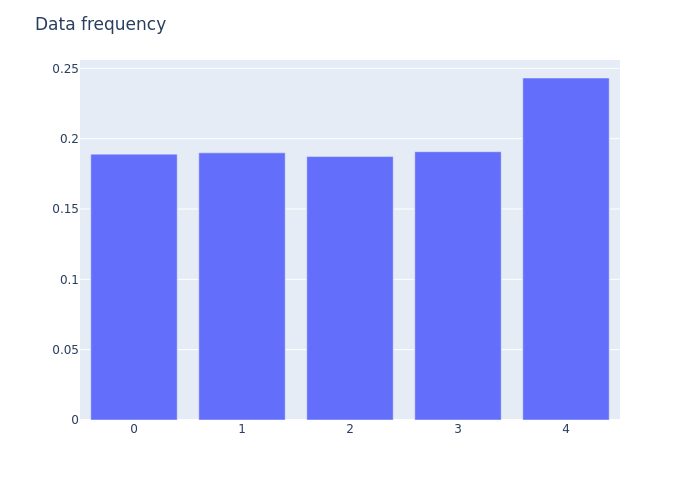

In [3]:
fig = EDA_missingness.bar(df)
fig.show('png')

Below is an example of downsampling the data and visualize the frequency of each new bins.

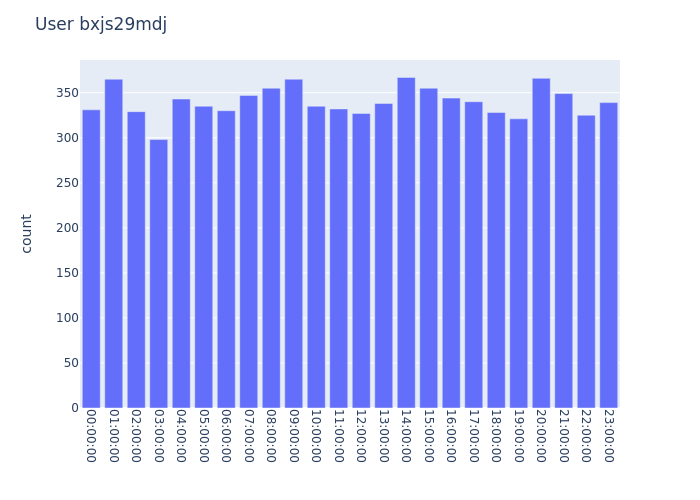

In [4]:
fig = EDA_missingness.bar_count(df[[0]],title="User bxjs29mdj", yaxis_title='count', sampling_freq='H')
fig.show('png')     

We can also create a missingness matrix visualization for the dataframe.

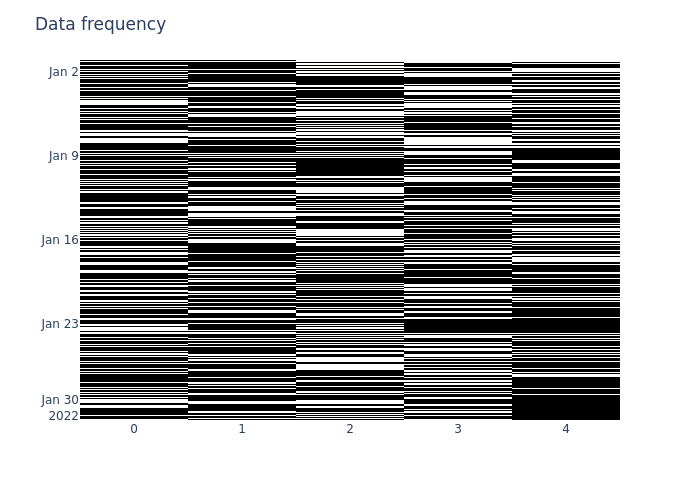

In [5]:
fig = EDA_missingness.matrix(df, sampling_freq='5T')
fig.show('png')

Finally, we can plot a heatmap to display the correlation between missing data.

Correlation ranges from -1 to 1. -1 means that if one variable appears then the other will definitely not. 0 means that there is no correlation between the missingness of two variables. 1 means that the two variables will always appear together.

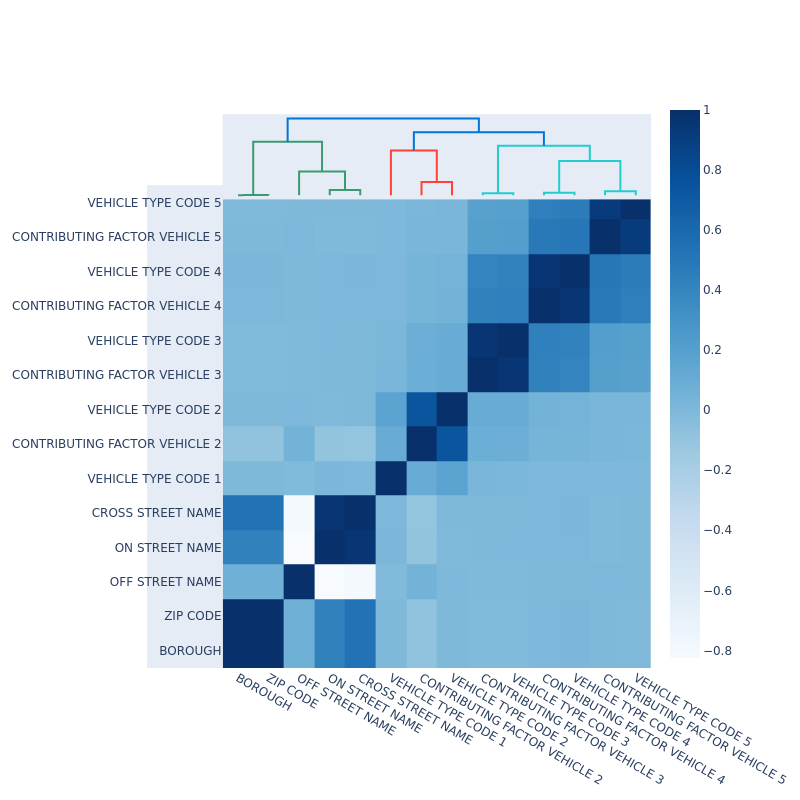

In [6]:
collisions = pd.read_csv("https://raw.githubusercontent.com/ResidentMario/missingno-data/master/nyc_collision_factors.csv")

fig = EDA_missingness.heatmap(collisions)
fig.show('png')